# Random forset to get optimal scores

We'll apply random forest classifier to fine-tune EVA scores. 

1. Load EVA data frame.
2. Load pharmaproject data.
3. Load epmc data.
4. Add epmc vector indicating if the evidence is in empc data.
5. Apply random forest classifier.
6. Extract weights.
7. Based on the weights calculate weights for each evidence then calculate ROC against pharmaproject data

In [291]:
import pandas as pd 
import json
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

def harmonic_sum(data, scale_factor=1, cap=None):
    """
    Returns an harmonic sum for the data passed
    Args:
        data (list): list of floats to compute the harmonic sum from
        scale_factor (float): a scaling factor to multiply to each datapoint. Defaults to 1
        cap (float): if not None, never return an harmonic sum higher than the cap value.
    Returns:
        harmonic_sum (float): the harmonic sum of the data passed
    """
    
    data.sort(reverse=True)
    harmonic_sum = sum(s / ((i+1) ** scale_factor) for i, s in enumerate(data))
    
    # Applying cap:
    if cap is not None and harmonic_sum > cap:
        return cap
      
    return harmonic_sum

def scaling_vectors(array, target_min=0, target_max=1):
    '''
    Linear scaling of an array between two targets
    '''

    array_max = array.max()
    array_min = array.min()

    scaled = []

    for value in array:
        fract = (value - array_min)/(array_max - array_min)
        scaled.append((target_max - target_min)*fract + target_min)

    return np.array(scaled)


def generate_evidence_score(transformed_data, y_data):
    """
    Once the categorical features are processed the table is passed to this 
    """
    
    # Run estimator:
    print('Running estimator...')
    rf = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=123456)
    rf.fit(transformed_data,y_data)    
    
    # Extracting weight:
    print('Extract weights...')
    weight_series = pd.Series(rf.feature_importances_, index=transformed_data.columns)
        
    ##
    ## Scaling review status 
    ##
    print('Scaling reivew status')    
    rev_status_scaled = weight_series['review_status_ordinal'] * scaling_vectors(transformed_data[rev_status_column_label])

    ##
    ## Scaling variant consequences:
    ##
    print('Scaling variant consequences...')
    consequences_scaled = weight_series['consequences_ordinal'] * scaling_vectors(eva_model_data[consequences_column_label])
    
    ##
    ## Summarizing clinical significance scores:
    ##
    print('Scaling clinical significance')
    for column, weight in weight_series.loc[[True if 'clin' in x else False for x in weight_series.index ]].iteritems():
        transformed_data[column] = transformed_data[column] * weight

    clin_sig_weighted = transformed_data[[x for x in transformed_data.columns if 'clin' in x]].apply(max, axis=1)

    ##
    ## Combine all weights and scale:
    ##
    print('Combining scores')    
    combined = clin_sig_weighted * consequences_scaled * rev_status_scaled
    scaled = scaling_vectors(combined)
    
    return scaled
    

### Reading data:

In [225]:
##
## EVA Read data:
##
eva_df = pd.read_csv('updated_eva.tsv.gz', compression='infer', sep='\t')
eva = eva_df[['target','disease','star','review_status','clinical_significance','consequence']]
eva.clinical_significance = eva.clinical_significance.apply(lambda x: json.loads(x))


print(f'Number of entries in eva: {len(eva)}')
print(f'Number of disease/target associations pair: {len(eva[["target","disease"]].drop_duplicates())}')
print(eva.head())

Number of entries in eva: 574097
Number of disease/target associations pair: 21548
            target        disease  star                   review_status  \
0  ENSG00000154803  Orphanet_2903     0  no assertion criteria provided   
1  ENSG00000186832  Orphanet_2337     0  no assertion criteria provided   
2  ENSG00000103197   Orphanet_805     0           no assertion provided   
3  ENSG00000103197   Orphanet_805     0           no assertion provided   
4  ENSG00000103197   Orphanet_805     0           no assertion provided   

  clinical_significance               consequence  
0          [pathogenic]        frameshift_variant  
1          [pathogenic]  protein_altering_variant  
2        [not provided]        frameshift_variant  
3        [not provided]        frameshift_variant  
4        [not provided]        frameshift_variant  


/Users/dsuveges/opt/anaconda3/envs/jupyter/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


Reading and processing pharmaproject data.

In [223]:
pharma_project_file = '/Users/dsuveges/project/issue-1166_benchmarking_clingen_evidences/abbvie_pharmaprojects_2018_mapped.csv'

# Reading pharmaproject file as dataframe:
pharma_df = pd.read_csv(pharma_project_file)

# Renaming columns for easy handling:
pharma_df.rename(columns={
    'ensembl_id': 'target',
    'id': 'disease',
    'lApprovedUS.EU': 'approved'
}, inplace=True)

print(f'Number of entries in pharmaproject: {len(pharma_df)}')
print(f'Number of disease/target associations pair: {len(pharma_df[["target","disease"]].drop_duplicates())}')
print(pharma_df.head())

Number of entries in pharmaproject: 22947
Number of disease/target associations pair: 22947
            target  approved      disease
0  ENSG00000119535     False  EFO_1001255
1  ENSG00000151617     False  EFO_1000014
2  ENSG00000012779     False  EFO_0003894
3  ENSG00000026508     False  EFO_0003894
4  ENSG00000057252     False  EFO_0003894


Reading literature evidence

rows: 32570
unique associations: 20289
rows: 20289
unique associations: 20289
            target        disease  assoc_score
0  ENSG00000000938    EFO_0000668     1.138000
1  ENSG00000000938  Orphanet_1359     1.500000
2  ENSG00000000971    EFO_0000546     0.978000
3  ENSG00000000971    EFO_0001365     2.085433
4  ENSG00000000971    EFO_0003768     0.640000


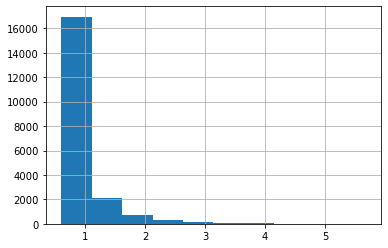

In [255]:
literature_df = pd.read_parquet('/Users/dsuveges/project/evidences/20.06_evidence_data.filtered.parquet')
literature_df.rename(columns={
    'efo_code': 'disease',
    'gene_id': 'target'
}, inplace=True)

# Applying score threshold:
literature_df = literature_df.loc[literature_df.assoc_score >= 0.6]

print(f'rows: {len(literature_df)}')
print(f'unique associations: {len(literature_df[["disease","target"]].drop_duplicates())}')


summed_data = []

for (target, disease), group in literature_df.groupby(['target', 'disease']):
    summed_data.append({
        'target': target,
        'disease': disease,
        'assoc_score': harmonic_sum(group.assoc_score.tolist())
    }) 

literature_assoc = pd.DataFrame(summed_data)

print(f'rows: {len(literature_assoc)}')
print(f'unique associations: {len(literature_assoc[["disease","target"]].drop_duplicates())}')
print(literature_assoc.head())
literature_assoc.assoc_score.hist()

#### Merging EVA data with Pharmaproject:

In [226]:
eva = eva.merge(pharma_df, on=['disease', 'target'], how='left')
eva['test_variable'] = eva.approved.apply(lambda x: 1 if x == False or x == True else 0)
eva.head()

,target,disease,star,review_status,clinical_significance,consequence,approved,test_variable
0,ENSG00000154803,Orphanet_2903,0,no assertion criteria provided,[pathogenic],frameshift_variant,NaN,0
1,ENSG00000186832,Orphanet_2337,0,no assertion criteria provided,[pathogenic],protein_altering_variant,NaN,0
2,ENSG00000103197,Orphanet_805,0,no assertion provided,[not provided],frameshift_variant,NaN,0
3,ENSG00000103197,Orphanet_805,0,no assertion provided,[not provided],frameshift_variant,NaN,0
4,ENSG00000103197,Orphanet_805,0,no assertion provided,[not provided],frameshift_variant,NaN,0


### Processing categorical variables

prepare data for ML

In [234]:
# Get unique clinical significance values:
eva['clinical_signif'] = eva.clinical_significance.apply(lambda x: x[0] if len(x) == 1 else None)

# Generate dummy features from clinical significance values:
eva_test_data = pd.get_dummies(eva, prefix='clin_sig', columns=['clinical_signif'])
print(eva_test_data.head())
# Update dummy columns were more then one clinical significance value is available:
for i, row in eva.loc[eva.clinical_signif.isna()].iterrows():
    for sig_val in row['clinical_significance']:
        eva_test_data.loc[i,f'clin_sig_{sig_val}'] = 1
        

            target        disease  star                   review_status  \
0  ENSG00000154803  Orphanet_2903     0  no assertion criteria provided   
1  ENSG00000186832  Orphanet_2337     0  no assertion criteria provided   
2  ENSG00000103197   Orphanet_805     0           no assertion provided   
3  ENSG00000103197   Orphanet_805     0           no assertion provided   
4  ENSG00000103197   Orphanet_805     0           no assertion provided   

  clinical_significance               consequence approved  test_variable  \
0          [pathogenic]        frameshift_variant      NaN              0   
1          [pathogenic]  protein_altering_variant      NaN              0   
2        [not provided]        frameshift_variant      NaN              0   
3        [not provided]        frameshift_variant      NaN              0   
4        [not provided]        frameshift_variant      NaN              0   

   clin_sig_affects  clin_sig_association  ...  \
0                 0                 

In [281]:
# Review status is an ordinal variable. Mapping to numbers:
review_status_order_map = {
    'no assertion provided': 1,
    'no assertion criteria provided': 2,
    'criteria provided, conflicting interpretations': 3,
    'criteria provided, single submitter': 4,
    'criteria provided, multiple submitters, no conflicts': 5,
    'reviewed by expert panel': 6,
    'practice guideline': 7
}

# Variant consequence is also an ordinal variable but it is not easy to map.
# Ordered list of consequences are fetched from Ensembl: 
# https://www.ensembl.org/info/genome/variation/prediction/predicted_data.html
all_ordered_consequences = [
    'transcript_ablation',
    'splice_acceptor_variant',
    'splice_donor_variant',
    'stop_gained',
    'frameshift_variant',
    'stop_lost',
    'start_lost',
    'transcript_amplification',
    'inframe_insertion',
    'inframe_deletion',
    'missense_variant',
    'protein_altering_variant',
    'splice_region_variant',
    'incomplete_terminal_codon_variant',
    'start_retained_variant',
    'stop_retained_variant',
    'synonymous_variant',
    'coding_sequence_variant',
    'mature_miRNA_variant',
    '5_prime_UTR_variant',
    '3_prime_UTR_variant',
    'non_coding_transcript_exon_variant',
    'intron_variant',
    'NMD_transcript_variant',
    'non_coding_transcript_variant',
    'upstream_gene_variant',
    'downstream_gene_variant',
    'TFBS_ablation',
    'TFBS_amplification',
    'TF_binding_site_variant',
    'regulatory_region_ablation',
    'regulatory_region_amplification',
    'feature_elongation',
    'regulatory_region_variant',
    'feature_truncation',
    'intergenic_variant'
]

# # Extract all used consequences:
# eva_consequences_order_map = {}

# # Looking up all consequence terms in an increasing order of significance:
# index = 1
# for consequence in reversed(all_ordered_consequences):
    
#     # Add to map if the given term is in the dataframe:
#     if consequence in eva_test_data.consequence.unique():
#         eva_consequences_order_map[consequence] = index
#         index += 1
        
# Adding manual value:
eva_consequences_order_map['trinucleotide_repeat_expansion'] = int(len(eva_consequences_order_map)/2)
eva_consequences_order_map['short_tandem_repeat_expansion'] = int(len(eva_consequences_order_map)/2)

# Apply ordinal mapping:
eva_test_data['consequences_ordinal'] = eva_test_data.consequence.map(eva_consequences_order_map) # Map consequence values
eva_test_data['review_status_ordinal'] = eva_test_data.review_status.map(review_status_order_map) # Map review status values

eva_test_data.head()

,target,disease,star,review_status,clinical_significance,consequence,approved,test_variable,clin_sig_affects,clin_sig_association,...,clin_sig_likely pathogenic,clin_sig_not provided,clin_sig_other,clin_sig_pathogenic,clin_sig_protective,clin_sig_risk factor,clin_sig_uncertain significance,consequences_ordinal,review_status_ordinal,scaled_scores
0,ENSG00000154803,Orphanet_2903,0,no assertion criteria provided,[pathogenic],frameshift_variant,NaN,0,0,0,...,0,0,0,1,0,0,0,0.95,2,0.035074
1,ENSG00000186832,Orphanet_2337,0,no assertion criteria provided,[pathogenic],protein_altering_variant,NaN,0,0,0,...,0,0,0,1,0,0,0,0.70,2,0.023383
2,ENSG00000103197,Orphanet_805,0,no assertion provided,[not provided],frameshift_variant,NaN,0,0,0,...,0,1,0,0,0,0,0,0.95,1,0.000000
3,ENSG00000103197,Orphanet_805,0,no assertion provided,[not provided],frameshift_variant,NaN,0,0,0,...,0,1,0,0,0,0,0,0.95,1,0.000000
4,ENSG00000103197,Orphanet_805,0,no assertion provided,[not provided],frameshift_variant,NaN,0,0,0,...,0,1,0,0,0,0,0,0.95,1,0.000000


Generate features from clinical significance:

In [282]:
# Select model data:
eva_model_data = eva_test_data[[x for x in eva_test_data.columns if 'clin_sig' in x or '_ordinal' in x]]

# Add column with results:
eva_test_data['scaled_scores'] = generate_evidence_score(eva_model_data, eva_test_data.test_variable)


print(eva_test_data.loc[eva_test_data.approved == True].scaled_scores.mean())
print(eva_test_data[eva_test_data.test_variable == 1].scaled_scores.mean())
print(eva_test_data[eva_test_data.test_variable == 0].scaled_scores.mean())
print(eva_test_data.scaled_scores.mean())

Running estimator...
Extract weights...
Scaling reivew status
Scaling variant consequences...
Scaling clinical significance


/Users/dsuveges/opt/anaconda3/envs/jupyter/lib/python3.6/site-packages/ipykernel_launcher.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Combining scores
0.005138212167867545
0.007998432320528643
0.012335754018974528
0.01226939816538628


In [284]:
summed_data = []

for (target, disease), group in eva_test_data.groupby(['target', 'disease']):
    summed_data.append({
        'target': target,
        'disease': disease,
        'score_new_old_weights': harmonic_sum(group.scaled_scores.tolist())
    }) 

summed_eva_evidences = pd.DataFrame(summed_data)
summed_eva_evidences.head()

,target,disease,score_new_old_weights
0,ENSG00000000419,Orphanet_137,0.073377
1,ENSG00000000971,EFO_0001365,0.044852
2,ENSG00000000971,EFO_0003884,0.153590
3,ENSG00000000971,EFO_1001155,0.046940
4,ENSG00000000971,Orphanet_200421,0.041343


In [260]:
test_01 = summed_eva_evidences.merge(literature_assoc, on=["target","disease"], how='left')
test_01['literature'] = test_01.assoc_score.apply(lambda x: True if x >0 else False)
test_01.drop('assoc_score', axis=1, inplace=True)
test_01.head()

,target,disease,score,literature
0,ENSG00000000419,Orphanet_137,0.292546,False
1,ENSG00000000971,EFO_0001365,0.177500,True
2,ENSG00000000971,EFO_0003884,0.542857,False
3,ENSG00000000971,EFO_1001155,0.144299,False
4,ENSG00000000971,Orphanet_200421,0.172379,False


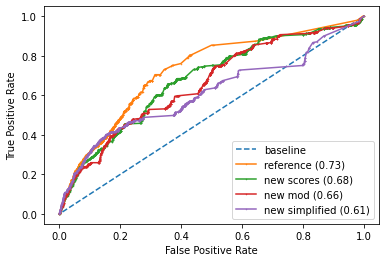

In [297]:
# New all:
fpr_new, tpr_new, thresholds = roc_curve(test_03.literature, test_03.score)
auc_new = roc_auc_score(test_03.literature, test_03.score)

# Reference scoring:
fpr_ref, tpr_ref, thresholds = roc_curve(test_03.literature, test_03.old_score)
auc_ref = roc_auc_score(test_03.literature, test_03.old_score)

# New modified scores:
fpr_mod, tpr_mod, thresholds = roc_curve(test_03.literature, test_03.score_new_old_weights)
auc_mod = roc_auc_score(test_03.literature, test_03.score_new_old_weights)

# New simplified:
fpr_simp, tpr_simp, thresholds = roc_curve(test_03.literature, test_03.new_simplified_score)
auc_simp = roc_auc_score(test_03.literature, test_03.new_simplified_score)

# Draw baseline:
pyplot.plot([x/100 for x in range(1,100,1)], [x/100 for x in range(1,100,1)], linestyle='--', label=f'baseline')

# Calculated curves:
pyplot.plot(fpr_ref, tpr_ref, marker='.', markersize = 1, label=f'reference ({auc_ref:.2})') # reference
pyplot.plot(fpr_new, tpr_new, marker='.', markersize = 1, label=f'new scores ({auc_new:.2})') # new
pyplot.plot(fpr_mod, tpr_mod, marker='.', markersize = 1, label=f'new mod ({auc_mod:.2})') # Modified new
pyplot.plot(fpr_simp, tpr_simp, marker='.', markersize = 1, label=f'new simplified ({auc_simp:.2})') # Simplified new


# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')

# Add legend:
pyplot.legend()


### Old scoring scheme:

In [266]:
eva_consequences_order_map = {'downstream_gene_variant': 0.6,
 'upstream_gene_variant': 0.6,
 'intron_variant': 0.65,
 'non_coding_transcript_exon_variant': 0.65,
 '3_prime_UTR_variant': 0.65,
 '5_prime_UTR_variant': 0.65,
 'mature_miRNA_variant': 0.65,
 'coding_sequence_variant': 0.95,
 'synonymous_variant': 0.65,
 'stop_retained_variant': 0.65,
 'incomplete_terminal_codon_variant': 0.9,
 'splice_region_variant': 0.9,
 'protein_altering_variant': 0.7,
 'missense_variant': 0.7,
 'inframe_deletion': 0.7,
 'inframe_insertion': 0.7,
 'start_lost': 0.95,
 'stop_lost': 0.9,
 'frameshift_variant': 0.95,
 'stop_gained': 0.95,
 'splice_donor_variant': 0.95,
 'splice_acceptor_variant': 0.95,
 'trinucleotide_repeat_expansion': 1,
 'short_tandem_repeat_expansion': 1}

old_evidence_score = eva_df[['target','disease','consequence']].copy()
old_evidence_score['evidence_score'] = old_evidence_score.consequence.map(eva_consequences_order_map)
old_evidence_score.head()

,target,disease,consequence,evidence_score
0,ENSG00000154803,Orphanet_2903,frameshift_variant,0.95
1,ENSG00000186832,Orphanet_2337,protein_altering_variant,0.70
2,ENSG00000103197,Orphanet_805,frameshift_variant,0.95
3,ENSG00000103197,Orphanet_805,frameshift_variant,0.95
4,ENSG00000103197,Orphanet_805,frameshift_variant,0.95


In [279]:
summed_data = []

for (target, disease), group in old_evidence_score.groupby(['target', 'disease']):
    summed_data.append({
        'target': target,
        'disease': disease,
        'old_score': harmonic_sum(group.evidence_score.tolist())
    }) 
    
test_02 = test_01.merge(pd.DataFrame(summed_data), on=['target', 'disease'], how='left')
test_02.head()

,target,disease,score,literature,old_score
0,ENSG00000000419,Orphanet_137,0.292546,False,3.881014
1,ENSG00000000971,EFO_0001365,0.177500,True,3.856524
2,ENSG00000000971,EFO_0003884,0.542857,False,0.950000
3,ENSG00000000971,EFO_1001155,0.144299,False,3.960965
4,ENSG00000000971,Orphanet_200421,0.172379,False,2.425278


In [285]:
# New method, but variants are weighted as old:
test_03 = test_02.merge(summed_eva_evidences, how='left')
test_03.head()

,target,disease,score,literature,old_score,score_new_old_weights
0,ENSG00000000419,Orphanet_137,0.292546,False,3.881014,0.073377
1,ENSG00000000971,EFO_0001365,0.177500,True,3.856524,0.044852
2,ENSG00000000971,EFO_0003884,0.542857,False,0.950000,0.153590
3,ENSG00000000971,EFO_1001155,0.144299,False,3.960965,0.046940
4,ENSG00000000971,Orphanet_200421,0.172379,False,2.425278,0.041343


### Score 4

Features:
* Consequence modified
* Review status simple ordinal

In [287]:
eva_test_data.head()

,target,disease,star,review_status,clinical_significance,consequence,approved,test_variable,clin_sig_affects,clin_sig_association,...,clin_sig_likely pathogenic,clin_sig_not provided,clin_sig_other,clin_sig_pathogenic,clin_sig_protective,clin_sig_risk factor,clin_sig_uncertain significance,consequences_ordinal,review_status_ordinal,scaled_scores
0,ENSG00000154803,Orphanet_2903,0,no assertion criteria provided,[pathogenic],frameshift_variant,NaN,0,0,0,...,0,0,0,1,0,0,0,0.95,2,0.010234
1,ENSG00000186832,Orphanet_2337,0,no assertion criteria provided,[pathogenic],protein_altering_variant,NaN,0,0,0,...,0,0,0,1,0,0,0,0.70,2,0.002924
2,ENSG00000103197,Orphanet_805,0,no assertion provided,[not provided],frameshift_variant,NaN,0,0,0,...,0,1,0,0,0,0,0,0.95,1,0.000000
3,ENSG00000103197,Orphanet_805,0,no assertion provided,[not provided],frameshift_variant,NaN,0,0,0,...,0,1,0,0,0,0,0,0.95,1,0.000000
4,ENSG00000103197,Orphanet_805,0,no assertion provided,[not provided],frameshift_variant,NaN,0,0,0,...,0,1,0,0,0,0,0,0.95,1,0.000000


In [288]:
transformed_data = eva_test_data[['consequences_ordinal', 'review_status_ordinal']]
score_test4 = eva_test_data[['target', 'disease']]

y_data = eva_test_data.test_variable

# Run estimator:
print('Running estimator...')
rf = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=123456)
rf.fit(transformed_data,y_data)    

# Extracting weight:
print('Extract weights...')
weight_series = pd.Series(rf.feature_importances_, index=transformed_data.columns)

##
## Scaling review status 
##
print('Scaling reivew status')    
rev_status_scaled = weight_series['review_status_ordinal'] * scaling_vectors(transformed_data[rev_status_column_label])

##
## Scaling variant consequences:
##
print('Scaling variant consequences...')
consequences_scaled = weight_series['consequences_ordinal'] * scaling_vectors(eva_model_data[consequences_column_label])

##
## Combine all weights and scale:
##
print('Combining scores')    
combined = consequences_scaled * rev_status_scaled
score_test4['new_simplified_score'] = scaling_vectors(combined)

# Harmonic sum:
summed_data = []

for (target, disease), group in score_test4.groupby(['target', 'disease']):
    summed_data.append({
        'target': target,
        'disease': disease,
        'new_simplified_score': harmonic_sum(group.new_simplified_score.tolist())
    }) 
    
test_03 = test_03.merge(pd.DataFrame(summed_data), on=['target', 'disease'], how='left')
test_03.head()

Running estimator...
Extract weights...
Scaling reivew status
Scaling variant consequences...
Combining scores


/Users/dsuveges/opt/anaconda3/envs/jupyter/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,target,disease,score,literature,old_score,score_new_old_weights,new_simplified_score
0,ENSG00000000419,Orphanet_137,0.292546,False,3.881014,0.073377,0.112650
1,ENSG00000000971,EFO_0001365,0.177500,True,3.856524,0.044852,0.086822
2,ENSG00000000971,EFO_0003884,0.542857,False,0.950000,0.153590,0.030702
3,ENSG00000000971,EFO_1001155,0.144299,False,3.960965,0.046940,0.087912
4,ENSG00000000971,Orphanet_200421,0.172379,False,2.425278,0.041343,0.043408


## Overlap between EVA/PharmaProject/ePMC


In [306]:
# Pharmaproject data:
pharma_assoc = pharma_df.copy()
pharma_assoc['approved'] = True

# Literature data:
lit_assoc = literature_df[['target','disease']].drop_duplicates()
lit_assoc['literature_poscon'] = True


overlap_df = eva_df[['target', 'disease']].merge(pharma_assoc, on=['disease','target'], how='left')
overlap_df = overlap_df.merge(lit_assoc, on=['disease','target'], how='left')

overlap_df['recovered'] = overlap_df.apply(lambda row: True if row['literature_poscon'] == True or row['approved'] == True else False,axis=1)


In [314]:
# All data:
all_evid = len(overlap_df)
all_assoc = len(overlap_df[['target','disease']].drop_duplicates())

# pharmap data:
pharmaproject_evid = len(overlap_df.loc[overlap_df.approved == True])
pharmaproject_assoc = len(overlap_df.loc[overlap_df.approved == True][['target','disease']].drop_duplicates())

# literature data:
lit_evid = len(overlap_df.loc[overlap_df.literature_poscon == True])
lit_assoc = len(overlap_df.loc[overlap_df.literature_poscon == True][['target','disease']].drop_duplicates())

# combined:
combined_evid = len(overlap_df.loc[overlap_df.recovered == True])
combined_assoc = len(overlap_df.loc[overlap_df.recovered == True][['target','disease']].drop_duplicates()) 

print(f'All EVA:\n\tevidence:{all_evid}, association: {all_assoc}')
print(f'Pharmaproject:\n\tevidence:{pharmaproject_evid}, association: {pharmaproject_assoc}')
print(f'Literature:\n\tevidence:{lit_evid}, association: {lit_assoc}')
print(f'Combined:\n\tevidence:{combined_evid}, association: {combined_assoc}')


All EVA:
	evidence:574097, association: 21548
Pharmaproject:
	evidence:8783, association: 294
Literature:
	evidence:25007, association: 301
Combined:
	evidence:30916, association: 520


In [329]:
import re

In [322]:
df = pd.read_csv('../../evidences/All_genes_20200928-1959.tsv', sep='\t')
df.loc[df.Phenotypes.isna(),'Phenotypes'] = df['Panel Name']
df = df.loc[~df.Phenotypes.str.contains(';')]

In [347]:
ds.Phenotypes.replace("[,()?\[\]]","",regex=True).head(100).tolist()

['Dystonia',
 'Perry syndrome',
 '{Parkinson disease late-onset susceptibility to} 168600',
 'Alexander disease 203450',
 'Basal ganglia calcification idiopathic 5 615483',
 'Basal ganglia calcification idiopathic 4 615007',
 'Cerebellar ataxia and hypogonadotropic hypogonadism 212840',
 'Thiamine metabolism dysfunction syndrome 2 biotin- or thiamine-responsive encephalopathy type 2 607483',
 'Basal ganglia calcification idiopathic 1 213600',
 'Frontotemporal dementia and/or amyotrophic lateral sclerosis 4 616439',
 'Basal ganglia calcification idiopathic 6 616413',
 'Dystonia 23 614860',
 'Parkinsons disease 18 614251',
 'GM1-gangliosidosis type III 230650',
 'Adult onset movement disorder',
 'Adult onset movement disorder',
 'Gabriele-de Vries syndrome',
 'Combined oxidative phosphorylation deficiency 6 300816',
 'Dentatorubro-pallidoluysian atrophy 125370',
 'Adult onset movement disorder',
 'Central hypoventilation syndrome congenital 209880',
 'Cardioencephalomyopathy fatal infant

In [327]:
# creating dictionary for trans table 
trans_dict ={"a": "X", "b": "Y", "c": "Z"} 
  
# creating translate table from dictionary 
trans_table ="abc".maketrans(trans_dict) 
trans_table

{97: 'X', 98: 'Y', 99: 'Z'}